# **Campaign conversion optimization using Polars dataframes**

***campaign_conversion.ipynb***

In this example, we load a dataset with customer information to optimize campaign channel assignments that maximize expected value subject to budget and channel capacity constraints. We showcase the capabilities of the Xpress Python API with the use of Polars dataframes to generate aggregate expressions for optimization.

&copy; Copyright 2025 Fair Isaac Corporation

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0.
 
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This example uses FICO&reg; Xpress software. By running it, you agree to the Community License terms of the [Xpress Shrinkwrap License Agreement](https://www.fico.com/en/shrinkwrap-license-agreement-fico-xpress-optimization-suite-on-premises) with respect to the FICO&reg; Xpress software. See the [licensing options](https://www.fico.com/en/fico-xpress-trial-and-licensing-options) overview for additional details and information about obtaining a paid license.

In [ ]:
# Install the necessary packages
%pip install -q xpress polars matplotlib seaborn pyarrow

## Problem description

In this **campaign conversion optimization** problem, we want to contact customers through different channels (SMS, Mail, Phone) to maximize the total expected value from contacts. Each customer can be contacted through at most one channel, and we need to decide which channel to use for each customer.

Customer data includes expected value and propensity to convert for each channel. Channel data includes contact costs and capacity constraints. **The optimized campaign must satisfy the following conditions**:
 - Each customer is contacted through at most one channel.
 - The total campaign cost must not exceed the available budget.
 - Each channel has a capacity limit (maximum percentage of customers that can be contacted).

The input data file `"data/customers1000.csv"` provides customer data with the following fields:
 - *CustomerIds*: Unique customer identifier.
 - *Name*: Customer name.
 - *Value*: Expected customer value.
 - *PropSMS*: Propensity to convert via SMS.
 - *PropMail*: Propensity to convert via Mail.
 - *PropPhone*: Propensity to convert via Phone.

The goal is to **maximize the total expected value while satisfying budget and channel capacity constraints**.

## Data preparation and analysis

We start by importing the essential libraries for optimization (`xpress`), data manipulation (`polars`), and visualization (`matplotlib`, `seaborn`). 

After defining the values for the constants needed for the mathematical model, we load the customer dataset from the CSV file into a **Polars dataframe**. Then, we display the first five rows to give a quick overview of the data structure and contents.

In [1]:
import xpress as xp
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

NUM_CUSTOMERS = 1000      # Number of customers to load, must be <= 1000
BUDGET = 1000             # Total campaign budget

# Load the customer dataset
customers = pl.read_csv("data/customers1000.csv", n_rows=NUM_CUSTOMERS)

# Customer data overview
print("Data sample for the first 5 rows:")
customers.head()

Data sample for the first 5 rows:


CustomerIds,Name,Value,PropSMS,PropMail,PropPhone
i64,str,i64,f64,f64,f64
1,"""Terry Sanchez""",2135,0.09122,0.141038,0.187281
2,"""Garrett Hicks""",2198,0.145643,0.189202,0.060199
3,"""Bernice Gordon""",2708,0.237127,0.080822,0.12173
4,"""Beverly Hill""",2857,0.106058,0.096307,0.18073
5,"""Marilyn Jennings""",2226,0.11221,0.239776,0.093367


The code below creates channel data and displays basic statistics about customers and their propensities across different channels.

In [2]:
# Create channel dataframe using Polars
channels = pl.from_dict({
    "ChannelIds": [0, 1, 2],
    "Name": ["SMS", "Mail", "Phone"],
    "Cost": [0.5, 1.2, 3.0],
    "Capacity": [100, 50, 40]       # Percentage of total customers
})

print("\nChannel information:")
print(channels)

print("\nCustomer statistics:")
print(f"\nTotal customers: {len(customers)}")
print(f"Average value: ${customers['Value'].mean():.2f}")
print(f"Min value: ${customers['Value'].min():.2f}")
print(f"Max value: ${customers['Value'].max():.2f}")
print(f"Median value: ${customers['Value'].median():.2f}")

print(f"Average propensities:")
print(f"  SMS:   {customers['PropSMS'].mean():.4f}")
print(f"  Mail:  {customers['PropMail'].mean():.4f}")
print(f"  Phone: {customers['PropPhone'].mean():.4f}")


Channel information:
shape: (3, 4)
┌────────────┬───────┬──────┬──────────┐
│ ChannelIds ┆ Name  ┆ Cost ┆ Capacity │
│ ---        ┆ ---   ┆ ---  ┆ ---      │
│ i64        ┆ str   ┆ f64  ┆ i64      │
╞════════════╪═══════╪══════╪══════════╡
│ 0          ┆ SMS   ┆ 0.5  ┆ 100      │
│ 1          ┆ Mail  ┆ 1.2  ┆ 50       │
│ 2          ┆ Phone ┆ 3.0  ┆ 40       │
└────────────┴───────┴──────┴──────────┘

Customer statistics:

Total customers: 1000
Average value: $2513.51
Min value: $2001.00
Max value: $3000.00
Median value: $2535.00
Average propensities:
  SMS:   0.1327
  Mail:  0.1334
  Phone: 0.1321


The code below creates visualizations of the customer data to better understand the distribution of values and propensities before the optimization.

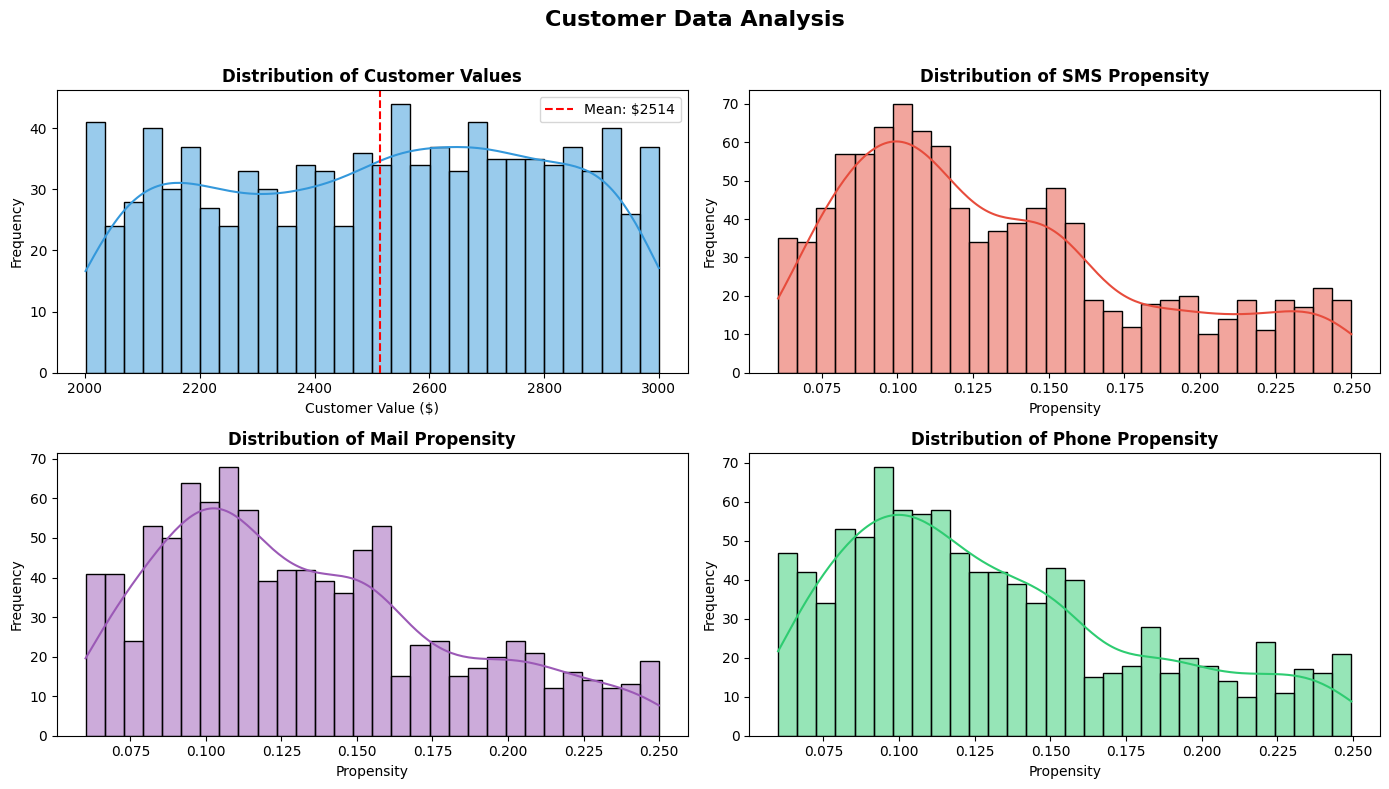

In [3]:
# Convert to pandas for visualization purposes
customers_pd = customers.to_pandas()

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('Customer Data Analysis', fontsize=16, fontweight='bold')

# Plot 1: Distribution of Customer Values
ax1 = axes[0, 0]
sns.histplot(customers_pd['Value'], bins=30, kde=True, ax=ax1, color='#3498db')
ax1.set_title('Distribution of Customer Values', fontweight='bold')
ax1.set_xlabel('Customer Value ($)')
ax1.set_ylabel('Frequency')
ax1.axvline(customers_pd['Value'].mean(), color='red', linestyle='--', label=f'Mean: ${customers_pd["Value"].mean():.0f}')
ax1.legend()

# Plot 2: Distribution of PropSMS
ax2 = axes[0, 1]
sns.histplot(customers_pd['PropSMS'], bins=30, kde=True, ax=ax2, color='#e74c3c')
ax2.set_title('Distribution of SMS Propensity', fontweight='bold')
ax2.set_xlabel('Propensity')
ax2.set_ylabel('Frequency')

# Plot 3: Distribution of PropMail
ax3 = axes[1, 0]
sns.histplot(customers_pd['PropMail'], bins=30, kde=True, ax=ax3, color='#9b59b6')
ax3.set_title('Distribution of Mail Propensity', fontweight='bold')
ax3.set_xlabel('Propensity')
ax3.set_ylabel('Frequency')

# Plot 4: Distribution of PropPhone
ax4 = axes[1, 1]
sns.histplot(customers_pd['PropPhone'], bins=30, kde=True, ax=ax4, color='#2ecc71')
ax4.set_title('Distribution of Phone Propensity', fontweight='bold')
ax4.set_xlabel('Propensity')
ax4.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## Model implementation and solution

We define binary decision variables $contact_{i,j}$ that indicate whether customer $i \in \mathcal{C}$ is contacted through channel $j \in \mathcal{CH}$ ($=1$), or not ($=0$).

Since Xpress variables cannot be directly stored in Polars dataframes, we create the variables using standard Python dictionaries indexed by (customer_id, channel_id) tuples.

In [4]:
# Create Xpress problem
p = xp.problem("Campaign Conversion")

# Extract index sets
customer_ids = customers["CustomerIds"].to_list()
channel_ids = channels["ChannelIds"].to_list()
num_customers = len(customer_ids)

# Decision variables: contact[i,j] = 1 if customer i contacted through channel j
contact = p.addVariables(customer_ids, channel_ids, vartype=xp.binary, name='contact')

# Metric tracking variables
MetricTotalCost = p.addVariable(name='MetricTotalCost')
MetricCostPerChannel = p.addVariables(channel_ids, vartype=xp.continuous, name='MetricCostPerChannel')
MetricContactPerChannel = p.addVariables(channel_ids, vartype=xp.continuous, name='MetricContactPerChannel')

print(f"Created {len(customer_ids) * len(channel_ids)} contact decision variables")
print(f"Created {len(channel_ids)*2 + 1} auxiliary variables for metric tracking")

Created 3000 contact decision variables
Created 7 auxiliary variables for metric tracking


The objective is to maximize the expected value from customer contacts:
$$\max \sum_{i \in \mathcal{C}} \sum_{j \in \mathcal{CH}} Value_i \cdot Prop_{i,j} \cdot Contact_{i,j}$$

We build this objective by iterating through customers and channels, using Polars filtering to extract the relevant propensity and value for each customer-channel pair.

**Polars Operations for Objective Function Building:**

The objective function uses nested loops with Polars `filter()` operations:
1. For each channel `j`, we extract the channel name: `channels.filter(pl.col("ChannelIds") == j)["Name"][0]`
2. For each customer `i`, we dynamically access the right propensity column using that name: `customers.filter(pl.col("CustomerIds") == i)[f"Prop{channel_name}"][0]`
3. We retrieve the customer value: `customers.filter(pl.col("CustomerIds") == i)["Value"][0]`

This pattern demonstrates how Polars can be integrated with optimization modeling using efficient filtering to construct complex mathematical expressions.

In [5]:
# Build objective expression using Polars filtering
ObjectiveValue = 0

for j in channel_ids:
    # Get channel name using Polars filter
    channel_name = channels.filter(pl.col("ChannelIds") == j)["Name"][0]
    
    for i in customer_ids:
        # Get customer propensity for this channel using Polars filter
        customer_prop = customers.filter(pl.col("CustomerIds") == i)[f"Prop{channel_name}"][0]
        customer_value = customers.filter(pl.col("CustomerIds") == i)["Value"][0]
        
        ObjectiveValue += contact[i, j] * customer_prop * customer_value

# Set objective function to maximize expected value
p.setObjective(ObjectiveValue, sense=xp.maximize)
print("Objective function created and added to the problem")

Objective function created and added to the problem


Next we model the following constraints:

- Each customer must be contacted through at most one channel: 
$$\sum_{j \in \mathcal{CH}} contact_{i,j} \leq 1 \quad \forall i \in \mathcal{C}$$

- Budget constraint: total cost must not exceed budget:
$$ \sum_{i \in \mathcal{C}} \sum_{j \in \mathcal{CH}} Cost_j \cdot contact_{i,j} \leq Budget$$

- Channel capacity: number of customers contacted per channel cannot exceed capacity:
$$ \sum_{i \in \mathcal{C}} contact_{i,j} \leq Capacity_j \cdot |\mathcal{C}| / 100 \quad \forall j \in \mathcal{CH}$$

**Polars Operations for Constraint Building:**

The constraints building process leverages the Polars' `filter()` method to extract specific values from dataframes. For example:
- `channels.filter(pl.col("ChannelIds") == j)["Cost"][0]` retrieves the cost for channel `j`
- `channels.filter(pl.col("ChannelIds") == j)["Capacity"][0]` retrieves the capacity limit for channel `j`

This approach allows us to dynamically look up channel-specific parameters while building the optimization model, making the code more maintainable and easier to understand compared to pre-processing all data into lists or dictionaries.

In [6]:
# Constraints 1: Each customer contacted through at most one channel
p.addConstraint(xp.Sum(contact[i, j] for j in channel_ids) <= 1 for i in customer_ids)

# Constraint 2: Budget constraint
p.addConstraint(MetricTotalCost <= BUDGET)

# Constraints 3: Channel capacity limits (using Polars filter)
p.addConstraint(
    xp.Sum(contact[i, j] for i in customer_ids) <= 
    channels.filter(pl.col("ChannelIds") == j)["Capacity"][0] / 100 * num_customers
    for j in channel_ids
)

# Constraint 4: Total contacts per channel (metric tracking)
p.addConstraint(
    xp.Sum(contact[i, j] for i in customer_ids) == MetricContactPerChannel[j]
    for j in channel_ids
)

# Constraint 5: Total cost per channel (metric tracking)
p.addConstraint(
    xp.Sum(contact[i, j] * channels.filter(pl.col("ChannelIds") == j)["Cost"][0]
    for i in customer_ids) == MetricCostPerChannel[j] 
    for j in channel_ids
)

# Constraint 6: Total cost equals sum of costs per channel (metric tracking)
p.addConstraint(
    xp.Sum(contact[i, j] * channels.filter(pl.col("ChannelIds") == j)["Cost"][0]
    for i in customer_ids for j in channel_ids) == MetricTotalCost
)

print(f"Model has {p.attributes.rows} constraints and {p.attributes.cols} variables")

Model has 1011 constraints and 3007 variables


Now we solve the problem and display the solution metrics and channel allocation.

In [7]:
p.controls.outputlog = 0        # Suppress output log

# Solve optimization problem
print("Starting optimization...")
solvestatus, solstatus = p.optimize()
print(f"Optimization complete. Status: {solstatus}")
print(f"Objective value: {p.attributes.objval:.2f}")

if solstatus in (xp.SolStatus.OPTIMAL, xp.SolStatus.FEASIBLE):
    # Process solution - add results to channels dataframe
    channels_solution = channels.sort("ChannelIds")
    channels_solution = channels_solution.with_columns([
        pl.Series(name="MetricCostPerChannel", values=list(p.getSolution(MetricCostPerChannel).values()), dtype=pl.Float64),
        pl.Series(name="MetricContactPerChannel", values=list(p.getSolution(MetricContactPerChannel).values()), dtype=pl.Float64)
    ])
    
    # Process solution - add assigned actions to customers dataframe
    customers_solution = customers.sort("CustomerIds")
    contact_solution = p.getSolution(contact)
    list_actions = [key[1] for key, value in contact_solution.items() if value > 0.5]
    
    customers_solution = customers_solution.with_columns([
        pl.Series(name="Action", values=list_actions, dtype=pl.Int64)
    ])
    
    # Add action names by mapping channel IDs to names
    list_action_names = [
        channels.filter(pl.col("ChannelIds") == action_id)["Name"][0]
        for action_id in customers_solution['Action']
    ]
    customers_solution = customers_solution.with_columns([
        pl.Series(name="ActionName", values=list_action_names)
    ])
    
    print("\n" + "="*60)
    print("CAMPAIGN OPTIMIZATION SOLUTION")
    print("="*60)
    print(f"\nObjective Value:       {p.attributes.objval:,.2f}")
    print(f"Total Cost:            ${p.getSolution(MetricTotalCost):,.2f}")
    
    print("\nChannel Allocation:")
    channel_display = channels_solution.select([
        "Name",
        "MetricContactPerChannel",
        "MetricCostPerChannel"
    ])
    print(channel_display)
    
    print("\nCustomer Assignment Summary:")
    assignment_summary = customers_solution.group_by("ActionName").agg([
        pl.len().alias("Count"),
        pl.col("Value").mean().alias("AvgValue")
    ]).sort("Count", descending=True)
    print(assignment_summary)
else:
    print("Optimization did not find a solution.")
    print("Status:", p.attributes.solvestatus)

Starting optimization...
Optimization complete. Status: 1
Objective value: 441490.38

CAMPAIGN OPTIMIZATION SOLUTION

Objective Value:       441,490.38
Total Cost:            $999.90

Channel Allocation:
shape: (3, 3)
┌───────┬─────────────────────────┬──────────────────────┐
│ Name  ┆ MetricContactPerChannel ┆ MetricCostPerChannel │
│ ---   ┆ ---                     ┆ ---                  │
│ str   ┆ f64                     ┆ f64                  │
╞═══════╪═════════════════════════╪══════════════════════╡
│ SMS   ┆ 525.0                   ┆ 262.5                │
│ Mail  ┆ 382.0                   ┆ 458.4                │
│ Phone ┆ 93.0                    ┆ 279.0                │
└───────┴─────────────────────────┴──────────────────────┘

Customer Assignment Summary:
shape: (3, 3)
┌────────────┬───────┬─────────────┐
│ ActionName ┆ Count ┆ AvgValue    │
│ ---        ┆ ---   ┆ ---         │
│ str        ┆ u32   ┆ f64         │
╞════════════╪═══════╪═════════════╡
│ SMS        ┆ 525   ┆

## Solution Visualization

Now we visualize the campaign optimization results using multiple plots to show channel allocation, costs, and customer distribution.

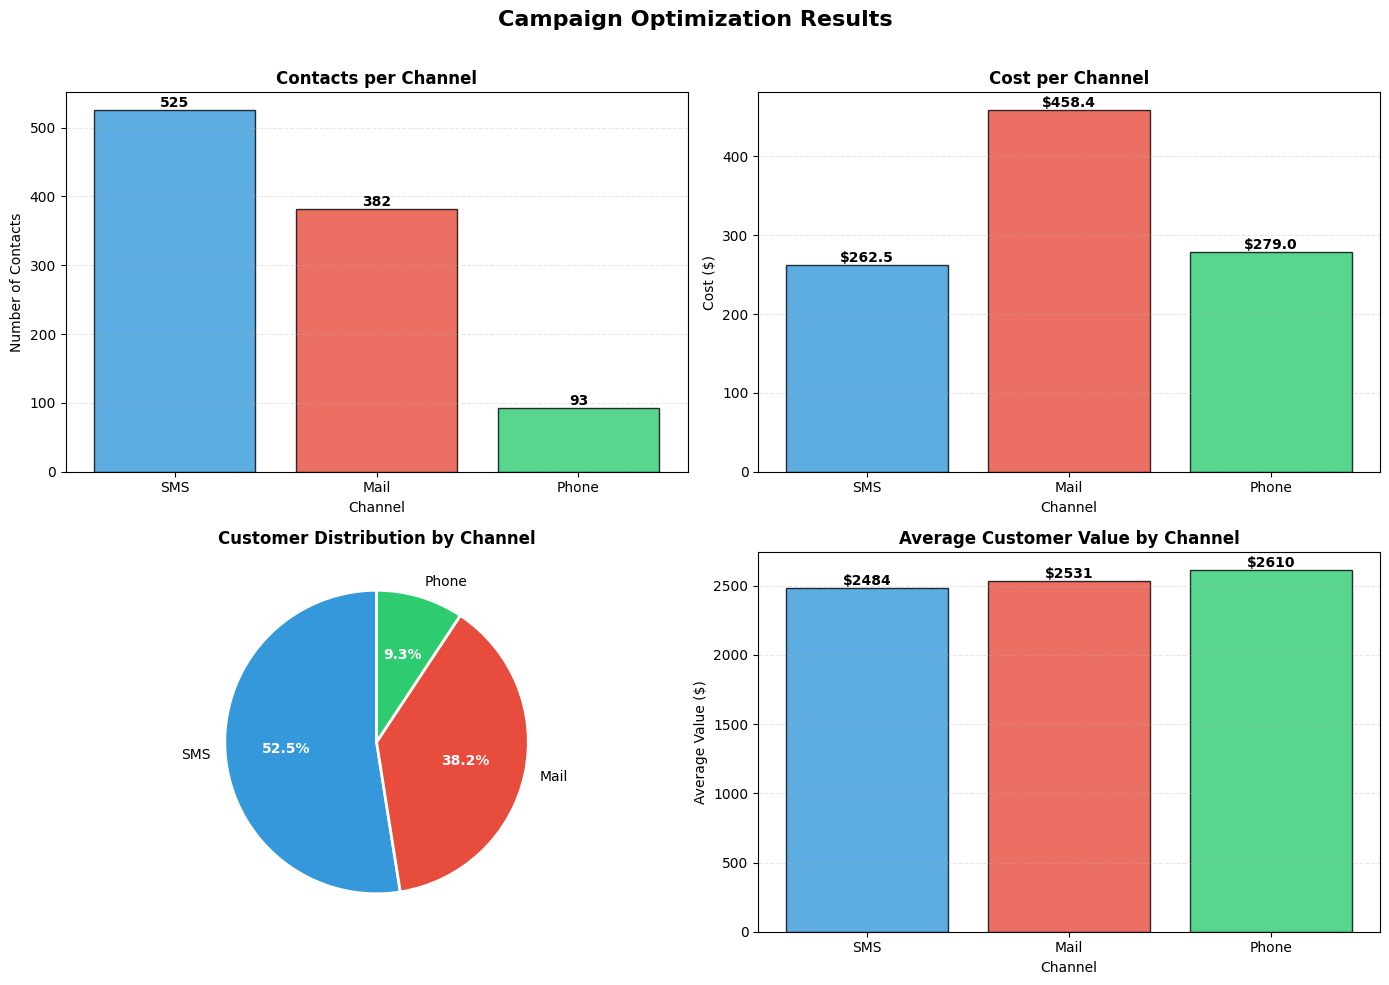

In [8]:
if solstatus in (xp.SolStatus.OPTIMAL, xp.SolStatus.FEASIBLE):
    # Set up the figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Campaign Optimization Results', fontsize=16, fontweight='bold')
    
    # Prepare data for visualization
    channel_names = channels_solution["Name"].to_list()
    contacts = channels_solution["MetricContactPerChannel"].to_list()
    costs = channels_solution["MetricCostPerChannel"].to_list()
    
    # Color scheme
    colors = ['#3498db', '#e74c3c', '#2ecc71']
    
    # Plot 1: Channel Contact Distribution (Bar Chart)
    ax1 = axes[0, 0]
    bars1 = ax1.bar(channel_names, contacts, color=colors, alpha=0.8, edgecolor='black')
    ax1.set_title('Contacts per Channel', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Number of Contacts', fontsize=10)
    ax1.set_xlabel('Channel', fontsize=10)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontweight='bold')
    
    # Plot 2: Channel Cost Distribution (Bar Chart)
    ax2 = axes[0, 1]
    bars2 = ax2.bar(channel_names, costs, color=colors, alpha=0.8, edgecolor='black')
    ax2.set_title('Cost per Channel', fontweight='bold', fontsize=12)
    ax2.set_ylabel('Cost ($)', fontsize=10)
    ax2.set_xlabel('Channel', fontsize=10)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'${height:.1f}',
                ha='center', va='bottom', fontweight='bold')
    
    # Plot 3: Customer Distribution by Channel (Pie Chart)
    ax3 = axes[1, 0]
    wedges, texts, autotexts = ax3.pie(
        contacts,
        labels=channel_names,
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        wedgeprops=dict(edgecolor='white', linewidth=2)
    )
    ax3.set_title('Customer Distribution by Channel', fontweight='bold', fontsize=12)
    
    # Make percentage text bold
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)
    
    # Plot 4: Average Customer Value by Channel
    ax4 = axes[1, 1]
    
    # Calculate average value per channel using Polars
    avg_values_by_channel = customers_solution.group_by("ActionName").agg([
        pl.col("Value").mean().alias("AvgValue")
    ])
    
    # Sort to match channel order
    channel_avg_values = []
    for name in channel_names:
        val = avg_values_by_channel.filter(pl.col("ActionName") == name)["AvgValue"]
        if len(val) > 0:
            channel_avg_values.append(val[0])
        else:
            channel_avg_values.append(0)
    
    bars4 = ax4.bar(channel_names, channel_avg_values, color=colors, alpha=0.8, edgecolor='black')
    ax4.set_title('Average Customer Value by Channel', fontweight='bold', fontsize=12)
    ax4.set_ylabel('Average Value ($)', fontsize=10)
    ax4.set_xlabel('Channel', fontsize=10)
    ax4.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bar in bars4:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'${height:.0f}',
                ha='center', va='bottom', fontweight='bold')
    
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig('campaign_optimization_results.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Cannot create visualizations - no solution available.")